In [169]:
from imprint.nb_util import setup_nb
setup_nb()

import numpy as np
import matplotlib.pyplot as plt
import scipy
import jax
import jax.numpy as jnp
import imprint.bound.normal as normal

2023-03-31 12:14:45,012 - imprint - DEBUG 
Enabling 64-bit floats in JAX.


In [170]:
def normal_KL(mu1, sig1, mu2, sig2):
    return jnp.log(sig2 / sig1) + (sig1 ** 2 + (mu1 - mu2) ** 2) / (2 * sig2 ** 2) - 0.5

In [171]:
#def pinsker(theta0, v, f0):
#    return f0 + jnp.sqrt(0.5 * normal_KL(theta0, 1, theta0 + v, 1))
    
def pinsker(theta0, v, f0):
    return f0 + jnp.abs(v) / 2.

In [172]:
def taylor(theta0, v, f0, df0):
    return f0 + df0 * v + 0.5 * v ** 2

In [173]:
theta0 = -0.25
vs = jnp.linspace(0, -theta0, 1000)
alpha = 0.025
eps = 1e-5
z_crit = scipy.stats.norm.isf(alpha)
f0 = scipy.stats.norm.sf(z_crit - theta0)
df0 = (scipy.stats.norm.sf(z_crit - theta0 - eps) - scipy.stats.norm.sf(z_crit - theta0 + eps)) / (2 * eps)

pinsker_v = jax.jit(jax.vmap(pinsker, in_axes=(None, 0, None)))
taylor_v = jax.jit(jax.vmap(taylor, in_axes=(None, 0, None, None)))
fwd_solver = normal.ForwardQCPSolver(1)
opt_qs = jax.vmap(fwd_solver.solve, in_axes=(0, None))(vs, f0)
tilt_bound_v_jit = jax.jit(jax.vmap(normal.tilt_bound_fwd_tile, in_axes=(0, None, 0, None)))

In [174]:
tie = scipy.stats.norm.sf(z_crit - (theta0 + vs)) * 100
pinsks = pinsker_v(theta0, vs, f0) * 100
bounds = tilt_bound_v_jit(opt_qs, 1, vs, f0) * 100
taylors = taylor_v(theta0, vs, f0, df0) * 100

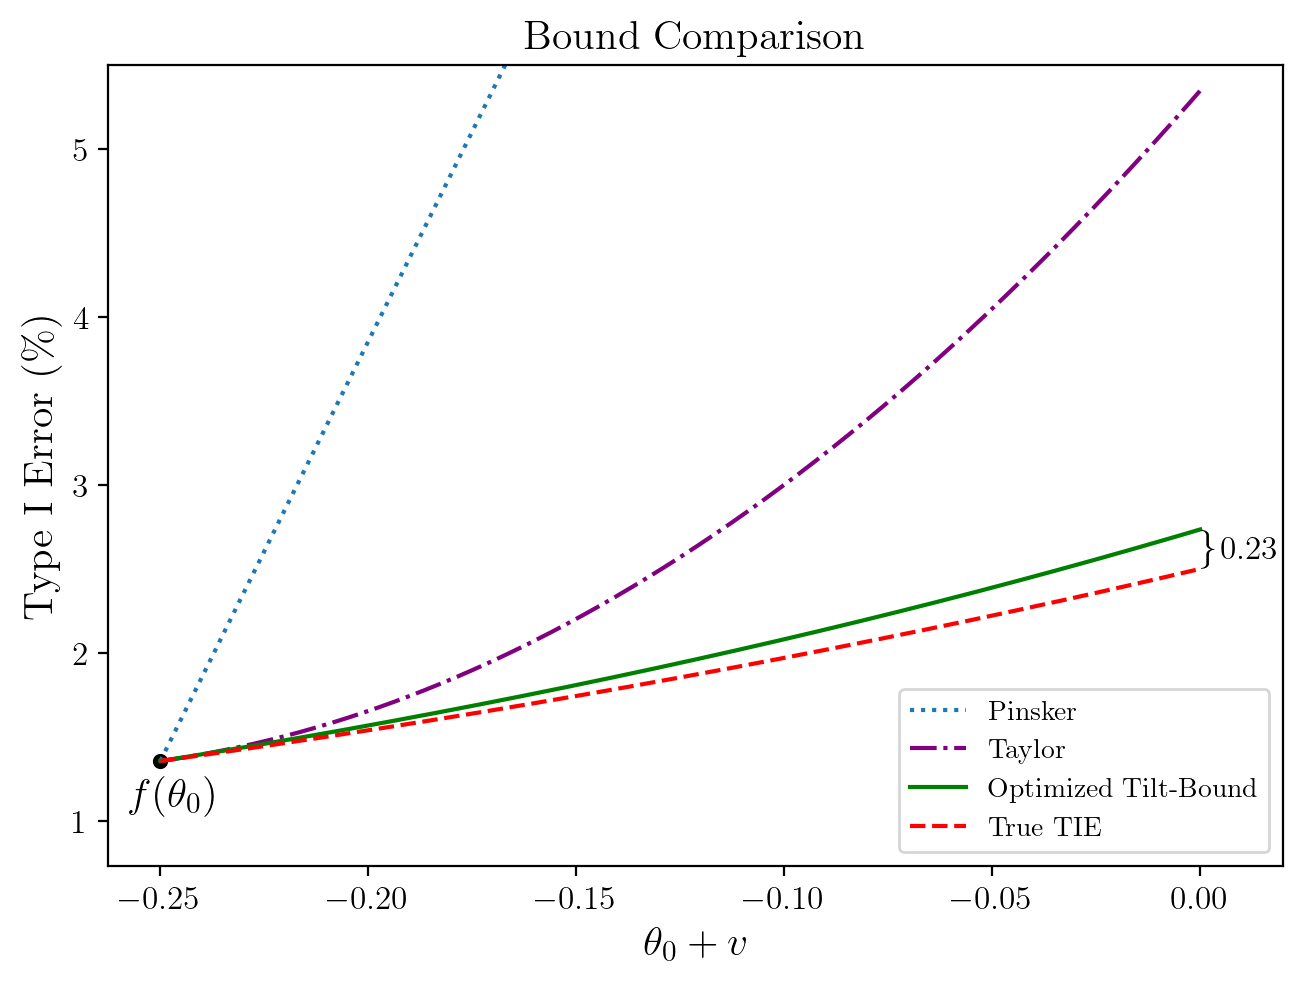

In [203]:
plt.figure(constrained_layout=True)

plt.scatter(theta0, tie[0], color="k", marker="o", s=20)
plt.plot(theta0 + vs, pinsks, linestyle='dotted', label='Pinsker')
plt.plot(theta0 + vs, taylors, linestyle='-.', label='Taylor', color='purple')
plt.plot(theta0 + vs, bounds, linestyle='-', label='Optimized Tilt-Bound', color='green')
plt.plot(theta0 + vs, tie, linestyle='--', label='True TIE', color='red')
plt.annotate("$f(\\theta_0)$", (theta0 * 1.03, tie[0] * 0.8))

x_last = theta0 + vs[-1]
tie_last = tie[-1]
yerr = bounds[-1] - tie_last
plt.annotate(
    r"\}",fontsize=14,
    xy=(x_last, tie_last + yerr / 4), 
)
plt.annotate(
    f"{yerr:.2f}", fontsize=12,
    xy=(x_last + 5e-3, tie_last + yerr / 4),
)

plt.title('Bound Comparison')
plt.xlabel('$\\theta_0 + v$')
plt.ylabel('Type I Error (\%)')
plt.xlim(left=None, right=0.02)
plt.ylim(bottom=None, top=alpha * 2.2 * 100)
plt.legend(prop={'size': 10})
plt.savefig('figures/bound_comparison.pdf', bbox_inches='tight')